In [1]:
import os
import pandas as pd
import numpy as np
import time

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras import models, optimizers
from keras.applications import VGG16

import matplotlib.pyplot as plt

Using TensorFlow backend.


**Extend the naive solution**
* Use VGG16 pretrained on ImageNet
    * ImageNet dataset contains 1.4million labeled images and 1000 classess including different species of cats and dogs

#### Read data

The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

In [2]:
PATH = '/Users/fi000980702/Documents/Work/Chapter5/data/'
train_dir = os.path.join(PATH, 'training')
val_dir = os.path.join(PATH, 'validation')

In [3]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')

In [4]:
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(val_cats_dir))
num_dogs_val = len(os.listdir(val_dogs_dir))
total_train = num_cats_train + num_dogs_train
total_val = num_cats_val + num_dogs_val

In [5]:
print('total training cat images:', num_cats_train)
print('total training dog images:', num_dogs_train)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 4000
total training dog images: 4000
total validation cat images: 1000
total validation dog images: 1000
--
Total training images: 8000
Total validation images: 2000


#### Pretrained VGG16 on ImageNet
* We omit the densely connected layer because the representations learned by the convolutional layer are likely to be more generic and therefore more reusable whereas the representations learned by the classifier will necessarily be spesific to the set of classes on which the model was trained. Therefore we set ```include_top=False```

In [6]:
image_height = 224
image_width = 224
channels = 3
batch_size = 16
epochs = 10

In [7]:
conv_base = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_height, image_width, channels))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

In [9]:
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size: (i+1)*batch_size]=features_batch
        labels[i*batch_size: (i+1)*batch_size]=labels_batch
        i += 1
        if i*batch_size>=sample_count:
            break
    return features, labels

In [10]:
train_features, train_labels = extract_features(train_dir, 8000)
validation_features, validation_labels = extract_features(val_dir, 2000)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
train_features = np.reshape(train_features, (8000, 7*7*512))
validation_features = np.reshape(validation_features, (2000, 7*7*512))

At this point, we can define our densely-connected classifier, and train it on the data and labels that we just recorded:

In [13]:
model = models.Sequential()
model.add(Dense(512, activation='relu', input_dim=7*7*512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

rmsprop=optimizers.RMSprop(lr=1e-5, decay=1e-5)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=15,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 8000 samples, validate on 2000 samples
Epoch 1/15
8000/8000 [==============================] - 62s 8ms/step - loss: 0.3810 - acc: 0.8191 - val_loss: 0.2750 - val_acc: 0.8770
Epoch 2/15
8000/8000 [==============================] - 56s 7ms/step - loss: 0.2403 - acc: 0.8991 - val_loss: 0.2309 - val_acc: 0.9000
Epoch 3/15
8000/8000 [==============================] - 54s 7ms/step - loss: 0.1967 - acc: 0.9205 - val_loss: 0.2001 - val_acc: 0.9195
Epoch 4/15
8000/8000 [==============================] - 54s 7ms/step - loss: 0.1749 - acc: 0.9315 - val_loss: 0.1889 - val_acc: 0.9255
Epoch 5/15
8000/8000 [==============================] - 54s 7ms/step - loss: 0.1550 - acc: 0.9355 - val_loss: 0.1889 - val_acc: 0.9240
Epoch 6/15
8000/8000 [==============================] - 55s 7ms/step - loss: 0.1421 - acc: 0.9451 - val_loss: 0.1893 - val_acc: 0.9245
Epoch 7/15
8000/8000 [==============================] - 55s 7ms/step - loss: 0.1277 - acc: 0.9514 - val_loss: 0.1774 - val_acc: 0.9275
Epoch 8

In [14]:
model.save('VGG16_binary_wo_aug.h5')

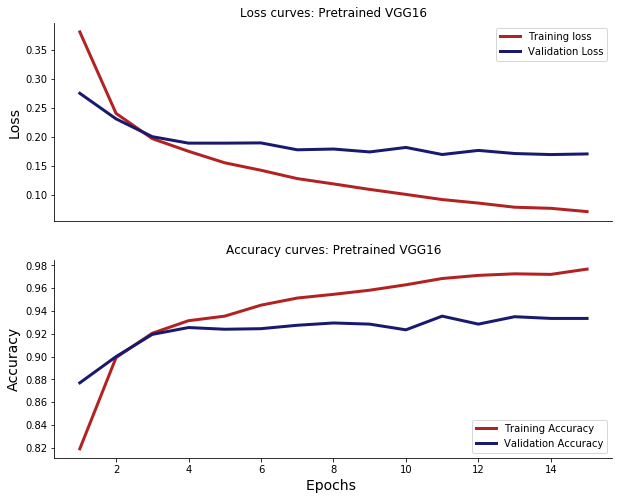

In [15]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,8))

history_dict = history.history
epochs = range(1, len(history_dict['acc'])+1)

ax0.plot(epochs, history_dict['loss'], 'firebrick', linewidth=3.0)
ax0.plot(epochs, history_dict['val_loss'], 'midnightblue', linewidth=3.0)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.tick_params(bottom=False)
ax0.set_xticklabels([])
ax0.set_title('Loss curves: Pretrained VGG16')
ax0.set_ylabel('Loss', fontsize=14)
ax0.legend(['Training loss', 'Validation Loss'], loc='best')

ax1.plot(epochs, history_dict['acc'], 'firebrick', linewidth=3.0)
ax1.plot(epochs, history_dict['val_acc'], 'midnightblue' ,linewidth=3.0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Accuracy curves: Pretrained VGG16')
ax1.set_xlabel('Epochs ', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')